In [38]:
#importing the libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import json
import string
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Input, Embedding, LSTM , Dense,GlobalMaxPooling1D,Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [39]:
#importing the dataset
with open('content.json') as content:
  data1 = json.load(content)

In [40]:
#getting all the data to lists
tags = []
inputs = []
responses={}
for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['input']:
    inputs.append(lines)
    tags.append(intent['tag'])

In [41]:
#converting to dataframe
data = pd.DataFrame({"inputs":inputs,
                     "tags":tags})

In [42]:
data

,inputs,tags
0,hello,greeting
1,hi there,greeting
2,nice to meet you,greeting
3,"hi, is this is the pirate's organization",greeting
4,any pirates here ?,greeting
...,...,...
76,tell me more about the pre requisites,prerequisites
77,give more details about the pre-requisites,prerequisites
78,What are the requirements,prerequisites
79,what's the basic requirements,prerequisites


In [80]:
data = data.sample(frac=1)

In [44]:
#removing punctuations
data['inputs'] = data['inputs'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
data['inputs'] = data['inputs'].apply(lambda wrd: ''.join(wrd))
data

,inputs,tags
52,which place do you live in,whereareyou
34,everything going on okay,howami
14,thank you,goodbye
12,hello pirates,greeting
32,are you fine,howami
...,...,...
58,how to join,join
40,what is your name,whoareyou
44,are you a bot,whoareyou
66,steps to join the pirates,join


In [45]:
#tokenize the data
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(data['inputs'])
train = tokenizer.texts_to_sequences(data['inputs'])
#apply padding
x_train = pad_sequences(train)

#encoding the outputs
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(data['tags'])

In [46]:
input_shape = x_train.shape[1]
print(input_shape)

8


In [47]:
#define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ",vocabulary)
output_length = le.classes_.shape[0]
print("output length: ",output_length)

number of unique words :  96
output length:  8


In [48]:
#creating the model

i = Input(shape=(input_shape,))
x = Embedding(vocabulary+1,10)(i)
x = LSTM(10,return_sequences=True)(x)
x = Flatten()(x)
x = Dense(output_length,activation="softmax")(x)
model  = Model(i,x)

In [49]:
#compiling the model
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [50]:
#training the model
train = model.fit(x_train,y_train,epochs=100)

Epoch 1/100
3/3 [==============================] - 1s 4ms/step - loss: 2.0789 - accuracy: 0.0617
Epoch 2/100
3/3 [==============================] - 0s 4ms/step - loss: 2.0753 - accuracy: 0.0988
Epoch 3/100
3/3 [==============================] - 0s 4ms/step - loss: 2.0720 - accuracy: 0.2099
Epoch 4/100
3/3 [==============================] - 0s 5ms/step - loss: 2.0685 - accuracy: 0.2469
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 2.0650 - accuracy: 0.2469
Epoch 6/100
3/3 [==============================] - 0s 4ms/step - loss: 2.0609 - accuracy: 0.2840
Epoch 7/100
3/3 [==============================] - 0s 4ms/step - loss: 2.0570 - accuracy: 0.2963
Epoch 8/100
3/3 [==============================] - 0s 4ms/step - loss: 2.0520 - accuracy: 0.3086
Epoch 9/100
3/3 [==============================] - 0s 4ms/step - loss: 2.0470 - accuracy: 0.3333
Epoch 10/100
3/3 [==============================] - 0s 4ms/step - loss: 2.0415 - accuracy: 0.3457
Epoch 11/100
3/3 [===========

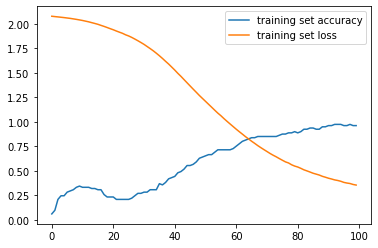

In [51]:
#plotting model accuracy
plt.plot(train.history['accuracy'],label='training set accuracy')
plt.plot(train.history['loss'],label='training set loss')
plt.legend()

In [89]:
while True:
  texts_p = []
  predition_input = input('You : ')
  #removing punctuation and converting to lowercase
  predition_input_1 = [letters.lower() for letters in  predition_input if letters not in string.punctuation]
  predition_input_1 = ''.join(predition_input_1)
  texts_p.append(predition_input_1)
  #tokenizing and padding
  predition_input_1 = tokenizer.texts_to_sequences(texts_p)
  predition_input_1 = np.array(predition_input_1).reshape(-1)
  predition_input_1 = pad_sequences([predition_input_1],input_shape)
  #getting output from model
  output = model.predict(predition_input_1)
  output = output.argmax()
  #finding the right tag and predicting
  response_tag = le.inverse_transform([output])[0]
  print("You : ", predition_input)
  print("Going Merry : ",random.choice(responses[response_tag]))
  if response_tag == "goodbye":
    break

You :  hello
Going Merry :  ahoy!!
You :  ho;w aer uou
Going Merry :  welcome aboard, how may I help you ?
You :  what os your name
Going Merry :  You can call me TechBot and I am here to Help you
You :  what is your name?
Going Merry :  You can call me TechBot and I am here to Help you
You :  
Going Merry :  okay. Have a nice day
